<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Diddier Cofré</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


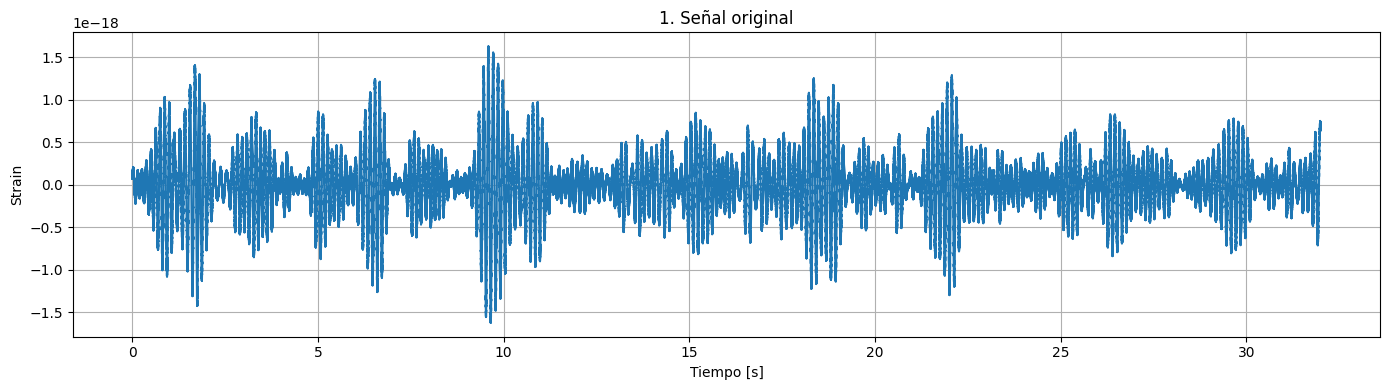

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, filtfilt, butter
from scipy.signal.windows import tukey
from IPython.display import Audio

# --------- 1. CARGAR LOS DATOS ---------
filename = 'L-L1_GWOSC_16KHZ_R1-1262879920-32.hdf5'

with h5py.File(filename, 'r') as f:
    strain = f['strain']['Strain'][:]
    dt = f['strain']['Strain'].attrs['Xspacing']

fs = int(1 / dt)
t = np.arange(len(strain)) * dt

# --------- 2. MOSTRAR SEÑAL ORIGINAL ---------
plt.figure(figsize=(14, 4))
plt.plot(t, strain, label="Original")
plt.xlabel("Tiempo [s]")
plt.ylabel("Strain")
plt.title("1. Señal original")
plt.grid()
plt.tight_layout()
plt.show()


## 2. Convertir en audio


In [ ]:
# --------- 3. AUDIO ORIGINAL ---------
print("2. Escuchar señal original:")
Audio(strain, rate=fs)

2. Escuchar señal original:


## 3. Análisis de Fourier



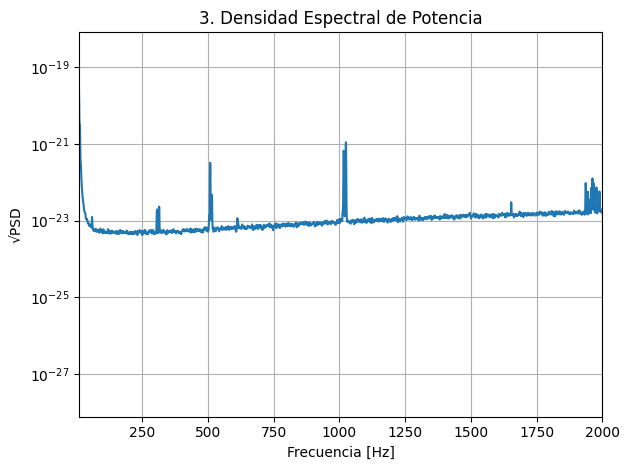

In [ ]:
# --------- 4. DENSIDAD ESPECTRAL DE POTENCIA (PSD) ---------
f, Pxx = welch(strain, fs=fs, nperseg=fs)
plt.semilogy(f, np.sqrt(Pxx))
plt.xlim(10, 2000)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("√PSD")
plt.title("3. Densidad Espectral de Potencia")
plt.grid()
plt.tight_layout()
plt.show()


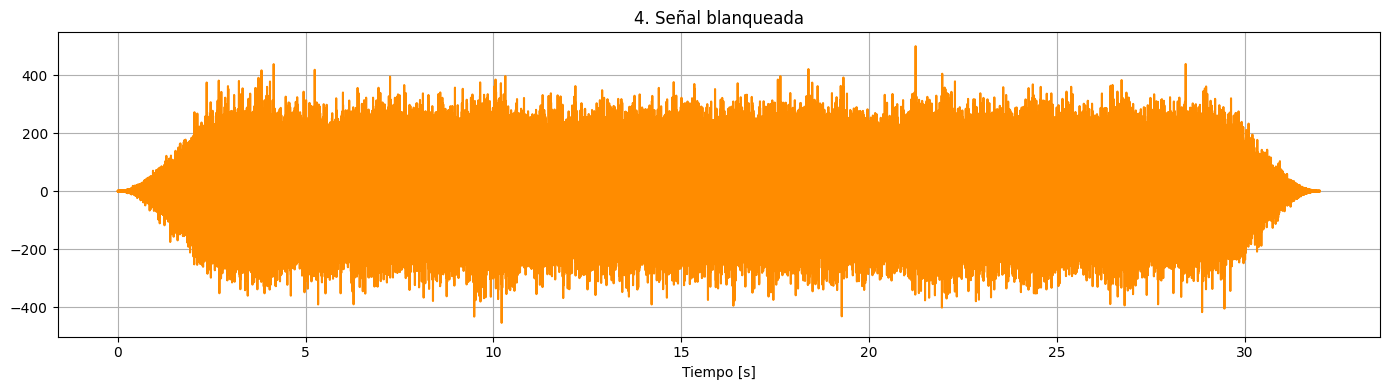

Audio después del blanqueamiento:


In [ ]:
# --------- 5. WINDOWING + BLANQUEAMIENTO ---------
window = tukey(len(strain), alpha=0.2)
strain_windowed = strain * window

# PSD para blanqueamiento
_, psd = welch(strain_windowed, fs=fs, nperseg=fs)
psd_interp = np.interp(np.fft.rfftfreq(len(strain), dt), f, psd)

# FFT y blanqueamiento
fft_strain = np.fft.rfft(strain_windowed)
whitened = np.fft.irfft(fft_strain / np.sqrt(psd_interp))

plt.figure(figsize=(14, 4))
plt.plot(t, whitened, color='darkorange')
plt.xlabel("Tiempo [s]")
plt.title("4. Señal blanqueada")
plt.grid()
plt.tight_layout()
plt.show()

print("Audio después del blanqueamiento:")
Audio(whitened, rate=fs)


## 4. Procesamiento


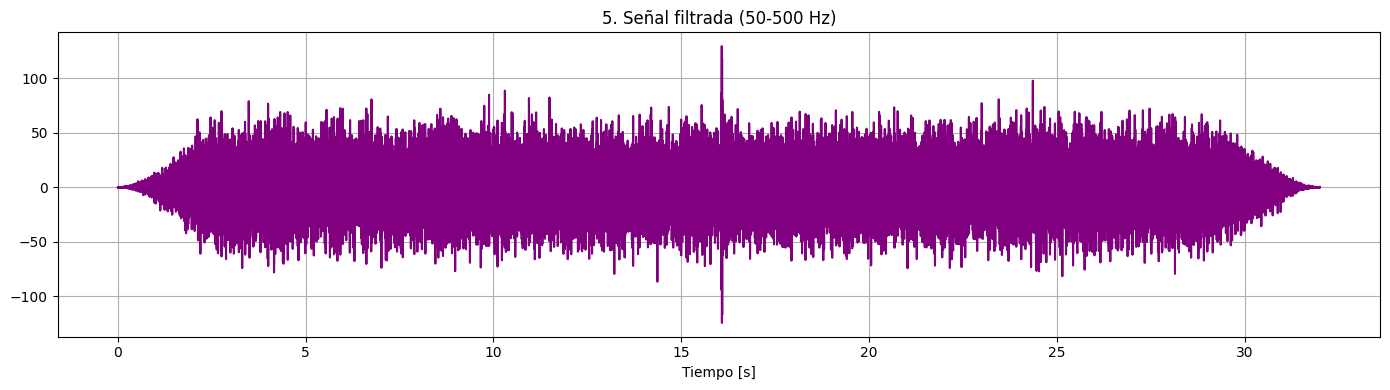

Audio filtrado:


In [ ]:
# --------- 6. FILTRADO PASABANDA (50-500 Hz) ---------
low, high = 50, 500
b, a = butter(4, [low/(fs/2), high/(fs/2)], btype='band')
filtered = filtfilt(b, a, whitened)

plt.figure(figsize=(14, 4))
plt.plot(t, filtered, color='purple')
plt.xlabel("Tiempo [s]")
plt.title("5. Señal filtrada (50-500 Hz)")
plt.grid()
plt.tight_layout()
plt.show()

print("Audio filtrado:")
Audio(filtered, rate=fs)


## Ventana Chirp y Espectrograma


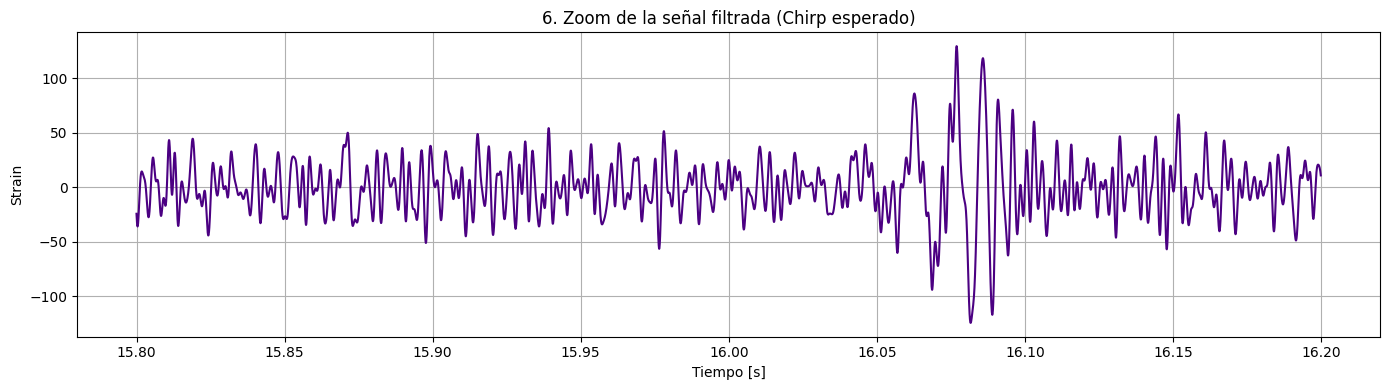

Audio en ventana del chirp (15.8 - 16.2 s):


In [ ]:
# --------- 7. ZOOM A LA VENTANA DEL CHIRP ---------
t_start, t_end = 15.8, 16.2
idx_start = int(t_start * fs)
idx_end = int(t_end * fs)

t_zoom = t[idx_start:idx_end]
filtered_zoom = filtered[idx_start:idx_end]

plt.figure(figsize=(14, 4))
plt.plot(t_zoom, filtered_zoom, color='indigo')
plt.title("6. Zoom de la señal filtrada (Chirp esperado)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Strain")
plt.grid()
plt.tight_layout()
plt.show()

print("Audio en ventana del chirp (15.8 - 16.2 s):")
Audio(filtered_zoom, rate=fs)


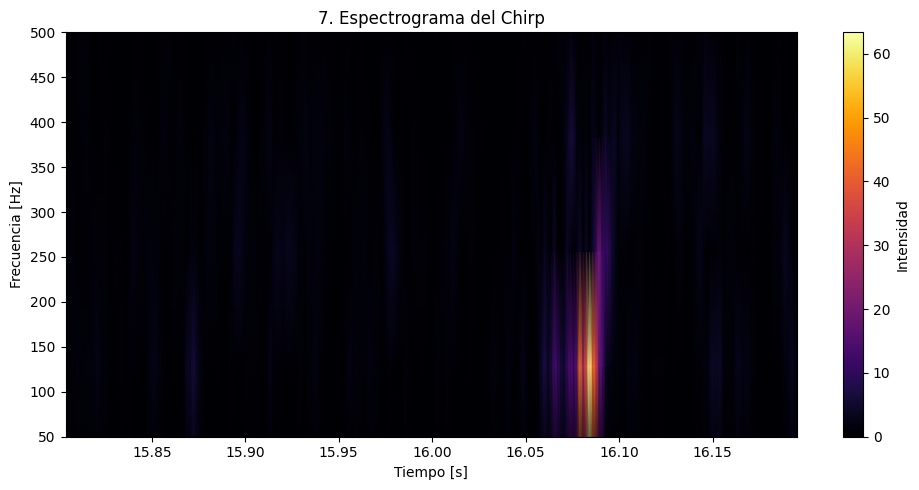

In [ ]:
# --------- 8. ESPECTROGRAMA ---------
from scipy.signal import spectrogram

f_spec, t_spec, Sxx = spectrogram(filtered_zoom, fs=fs, nperseg=128, noverlap=100)

plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec + t_start, f_spec, Sxx, shading='gouraud', cmap='inferno')
plt.colorbar(label='Intensidad')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title("7. Espectrograma del Chirp")
plt.ylim([50, 500])
plt.tight_layout()
plt.show()
